In [15]:
from datetime import date, timedelta
from joblib import Parallel, delayed
from functools import partial
import geopandas as gpd
import multiprocessing
import pandas as pd
import numpy as np
import argparse
import calendar
import datetime
import requests
import shapely
import pyproj
import shutil
import ee
import os

from helpers import *

In [30]:
year1 = "2015"
month1 = "8"
iso = "MEX"
ic = "LANDSAT/LC08/C01/T1_TOA"

In [31]:
ee.Initialize()

# Get the start and end dates of each month in the year to filter the imagery
dates = GetDays(year1, month1)

<AxesSubplot:>

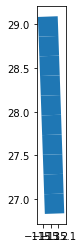

In [32]:
shp = gpd.read_file("./grid/rec25000_4326.shp")
shp[1000:1010].plot()

In [39]:
shp[shp["left"] == 1325000]#2675000, 1325000 2700000, 1350000 2700000, 1350000 2675000, 1325000 2675000)))	1325000	2675000	1350000	2700000

,left,bottom,right,top,shapeID,geometry,TileID
4898,1325000.0,1675000.0,1350000.0,1700000.0,4898,"POLYGON ((-103.34528 15.02106, -103.33718 15.2...",4898
4899,1325000.0,1700000.0,1350000.0,1725000.0,4899,"POLYGON ((-103.33718 15.24506, -103.32895 15.4...",4899
4900,1325000.0,1725000.0,1350000.0,1750000.0,4900,"POLYGON ((-103.32895 15.46905, -103.32058 15.6...",4900
4901,1325000.0,1750000.0,1350000.0,1775000.0,4901,"POLYGON ((-103.32058 15.69303, -103.31208 15.9...",4901
4902,1325000.0,1775000.0,1350000.0,1800000.0,4902,"POLYGON ((-103.31208 15.91700, -103.30344 16.1...",4902
...,...,...,...,...,...,...,...
4972,1325000.0,3525000.0,1350000.0,3550000.0,4972,"POLYGON ((-102.32166 31.56426, -102.30073 31.7...",4972
4973,1325000.0,3550000.0,1350000.0,3575000.0,4973,"POLYGON ((-102.30073 31.78722, -102.27958 32.0...",4973
4974,1325000.0,3575000.0,1350000.0,3600000.0,4974,"POLYGON ((-102.27958 32.01016, -102.25818 32.2...",4974
4975,1325000.0,3600000.0,1350000.0,3625000.0,4975,"POLYGON ((-102.25818 32.23308, -102.23655 32.4...",4975


In [33]:
shp.shape

(10507, 6)

In [34]:
shp["TileID"] = [i for i in range(0, len(shp))]

In [35]:
# shp.to_file("./data/tiles/tiles.shp")

In [36]:
shp.head()

,left,bottom,right,top,shapeID,geometry,TileID
0,-225000.0,1675000.0,-200000.0,1700000.0,0,"POLYGON ((-117.73178 15.05043, -117.73892 15.2...",0
1,-225000.0,1700000.0,-200000.0,1725000.0,1,"POLYGON ((-117.73892 15.27488, -117.74617 15.4...",1
2,-225000.0,1725000.0,-200000.0,1750000.0,2,"POLYGON ((-117.74617 15.49934, -117.75355 15.7...",2
3,-225000.0,1750000.0,-200000.0,1775000.0,3,"POLYGON ((-117.75355 15.72378, -117.76105 15.9...",3
4,-225000.0,1775000.0,-200000.0,1800000.0,4,"POLYGON ((-117.76105 15.94821, -117.76866 16.1...",4


In [40]:
map_sharpened = folium.Map(location=[29.19828501171627, -118.3712214497313], zoom_start = 6)

for col, row in shp[4000:4010].iterrows():

    cur_shp = row.geometry
    print(cur_shp.bounds)
    cur_shp = ConvertToFeature(cur_shp)
    
#     print(cur_shp)
    geometry = ee.Geometry.Rectangle(list(row.geometry.bounds))   
    
    
    
    os.mkdir(os.path.join("test_imagery", str(row.TileID)))
    
    # GET THE DOWNLOAD URL FOR THIS ONE - IT'S YOUR ORIGINAL IMAGE, CLOUDS & EVERYTHING
    raw_image = ee.ImageCollection(ic).filterDate(dates[0], dates[1]).filterBounds(cur_shp).first()  
    raw_image = raw_image.clip(cur_shp)
    
    raw_image_zip_name = os.path.join("test_imagery", str(row.TileID), str(row.TileID) + "_RI.zip")
    raw_image_link = raw_image.select(['B4', 'B3', 'B2']).getDownloadURL({'name': str(row.TileID), 'crs': 'EPSG:4326', 'fileFormat': 'GeoTIFF', 'region': geometry, 'scale': 30})    

#     r = requests.get(raw_image_link, allow_redirects = True)
#     open(raw_image_zip_name, 'wb').write(r.content)        
    
    
#     # GET THE DOWNLOAD URL FOR THIS ONE - IT'S YOUR MASK LAYER (POST-PROCESSING BINARIZES IT)
#     cloud_mask = ee.Algorithms.Landsat.simpleCloudScore(raw_image)
#     cloud_mask = cloud_mask.select(['cloud']).lte(0);
#     cloud_mask = raw_image.updateMask(cloud_mask);
    
#     cloud_mask_zip_name = os.path.join("test_imagery", str(row.TileID), str(row.TileID) + "_CM.zip")
#     cloud_mask_link = cloud_mask.select(['B2']).getDownloadURL({'name': str(row.TileID), 'crs': 'EPSG:4326', 'fileFormat': 'GeoTIFF', 'region': geometry, 'scale': 30})    
    
#     r = requests.get(cloud_mask_link, allow_redirects = True)
#     open(cloud_mask_zip_name, 'wb').write(r.content)       
    
    
#     # GET THE DOWNLOAD URL FOR THIS ONE - IT WILL BE YOUR CLOUD FREE IMAGE TO USE AS 'TRUTH'
#     no_clouds = ee.ImageCollection("LANDSAT/LC08/C01/T1").filterDate('2013-01-01', '2020-08-31').filterBounds(cur_shp)
#     no_clouds = ee.Algorithms.Landsat.simpleComposite(no_clouds)
#     no_clouds = no_clouds.clip(cur_shp)
    
#     no_clouds_zip_name = os.path.join("test_imagery", str(row.TileID), str(row.TileID) + "_NC.zip")
#     no_clouds_link = no_clouds.select(['B4', 'B3', 'B2']).getDownloadURL({'name': str(row.TileID), 'crs': 'EPSG:4326', 'fileFormat': 'GeoTIFF', 'region': geometry, 'scale': 30})    
    
#     r = requests.get(no_clouds_link, allow_redirects = True)
#     open(no_clouds_zip_name, 'wb').write(r.content)     
    
    map_sharpened.add_ee_layer(raw_image, {
        'bands': ['B4', 'B3', 'B2']}, 'rgb')
    
map_sharpened

(-105.7429515822471, 26.339208432619348, -105.48279135148223, 26.573380473170843)
(-105.73270239279692, 26.563892548653612, -105.47193500758641, 26.798146233552632)
(-105.72233210036056, 26.78856550744924, -105.46095084466614, 27.022901094781712)
(-105.71183967733269, 27.013227212004438, -105.4498377707157, 27.247644964532896)
(-105.70122407932044, 27.237877565075312, -105.43859467589812, 27.472377750289738)
(-105.690484244865, 27.462516469165063, -105.42722043224856, 27.697099359334587)
(-105.67961909515738, 27.687143826512898, -105.41571389337082, 27.921809698738368)
(-105.66862753374751, 27.911759539082567, -105.4040738941272, 28.146508675350063)
(-105.65750844624708, 28.136363508550687, -105.39229925032139, 28.371196195785853)
(-105.64626070002556, 28.360955636294594, -105.38038875837421, 28.595872166418026)


In [41]:
shp.loc[0]

id                                                        52.0
GEOLEVEL2                                            484002001
boxID                                                        0
geometry     POLYGON ((-118.3712214497313 29.19828501171627...
Name: 0, dtype: object

In [ ]:
# CM = Cloud Mask (Cloudy pixels represented as Null)
# RI = Raw Image (Image taken on specified date with clouds)
# NC = No Clouds (GEE Cloud Free Composite image)